In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


# 데이터 가져오기

In [13]:
import pandas as pd

# Assuming your Excel file is in your Google Drive at the specified path
# Replace 'your_excel_file.xlsx' with the actual name of your file
# Replace 'Your_Folder/your_excel_file.xlsx' with the path to your file in your Google Drive
file_path = '/content/drive/MyDrive/25-1/AIP/Team5/B2_data.xlsx'

# Read the Excel file into a pandas DataFrame
# If you need a specific sheet, you can add sheet_name='Sheet1'
df = pd.read_excel(file_path)

# Select the first 5 columns and the first 12 rows
# Note: If your Excel file has fewer than 5 columns or 12 rows, this will take all available.
# If you need exactly 5 columns and 12 rows, you might need more complex slicing
# or error handling depending on the structure of your Excel file.
df_subset = df.iloc[:66, 2:7]

# Now df_subset contains the first 12 rows and first 5 columns of your Excel file.
# You can display the first few rows to verify
print(df_subset.head())

   시험기간 여부  요일    시간  어플 상 이용 좌석 수  실제 이용 좌석 수
0        0   4  1100          12.0        15.0
1        0   4  1130          13.0        19.0
2        0   4  1200          13.0        16.0
3        0   4  1300          14.0        17.0
4        0   4  1330          14.0        21.0


In [14]:
# prompt: 어플 상 이용 좌석 수와 실제 이용 좌석 수가 빈 경우는 제외
print(f"The length before : {len(df_subset)}")
# Drop rows where 'App Seats' or 'Actual Seats' are empty (NaN)
df_subset = df_subset.dropna(subset=[df_subset.columns[2], df_subset.columns[4]]) # Assuming App Seats is the 3rd column and Actual Seats is the 5th column (0-indexed)

print(f"The length after : {len(df_subset)}")


The length before : 66
The length after : 60


In [15]:
from sklearn.model_selection import train_test_split

# Features (input) are the first 4 columns
X = df_subset.iloc[:, :4]

# Target (prediction) is the 5th column
y = df_subset.iloc[:, 4]

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)


Shape of X_train: (48, 4)
Shape of X_val: (12, 4)
Shape of y_train: (48,)
Shape of y_val: (12,)


In [19]:
print(X_train.head())
print('==================================================')
print(y_train.head())

    시험기간 여부  요일    시간  어플 상 이용 좌석 수
31        1   3  1030          11.0
3         0   4  1300          14.0
58        1   5  1200          11.0
17        0   1  1230          19.0
8         0   5  1130          11.0
31    13.0
3     17.0
58    12.0
17    19.0
8     17.0
Name: 실제 이용 좌석 수, dtype: float64


# 모델 생성

In [42]:
import torch.nn as nn
import torch.nn.functional as F

class BadRegressionModel(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, 128)  # Increased neurons
    self.bn1 = nn.BatchNorm1d(128)       # Added Batch Normalization
    self.dropout1 = nn.Dropout(0.3)     # Added Dropout
    self.fc2 = nn.Linear(128, 64)
    self.bn2 = nn.BatchNorm1d(64)
    self.dropout2 = nn.Dropout(0.3)
    self.fc3 = nn.Linear(64, 32)
    self.bn3 = nn.BatchNorm1d(32)
    self.dropout3 = nn.Dropout(0.3)
    self.fc4 = nn.Linear(32, 1)          # Output layer for regression

  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = self.dropout1(x)
    x = F.relu(self.bn2(self.fc2(x)))
    x = self.dropout2(x)
    x = F.relu(self.bn3(self.fc3(x)))
    x = self.dropout3(x)
    x = self.fc4(x)
    return x

class SimpleRegression(nn.Module):
  def __init__(self, input_dim):
      super().__init__()
      self.net = nn.Sequential(
          nn.Linear(input_dim, 32),
          nn.ReLU(),
          nn.Linear(32, 16),
          nn.ReLU(),
          nn.Linear(16, 1)
      )

  def forward(self, x):
      return self.net(x)


# Get input size from the training data
input_size = X_train.shape[1]
model = SimpleRegression(input_size).to(device)
model

SimpleRegression(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

# 모델 학습 & 검증


## 모델 학습

In [43]:
def train_model(model, X_train, y_train, criterion, optimizer, num_epochs=100):
  model.train()  # Set the model to training mode
  for epoch in range(num_epochs):
    # Convert pandas DataFrames to PyTorch tensors
    inputs = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    labels = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device) # Unsqueeze to match output shape

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example usage (you would define criterion and optimizer before calling this function)
# criterion = nn.MSELoss() # Example Loss function
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Example Optimizer
# train_model(model, X_train, y_train, criterion, optimizer)


## 모델 검증

In [45]:
# prompt: make function to validate model

def validate_model(model, X_val, y_val, criterion):
  model.eval() # Set the model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
    inputs = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    labels = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    print(f'Validation Loss: {loss.item():.4f}')

# Example usage:
# Assuming you have a trained model and the validation data X_val, y_val
# and a criterion (e.g., nn.MSELoss())
# criterion = nn.MSELoss() # Example Loss function
# validate_model(model, X_val, y_val, criterion)


## 학습 검증 시각화 진행

Epoch [100/10000], Loss: 9.0257
Epoch [200/10000], Loss: 7.1396
Epoch [300/10000], Loss: 6.5333
Epoch [400/10000], Loss: 6.1632
Epoch [500/10000], Loss: 5.8321
Epoch [600/10000], Loss: 5.5566
Epoch [700/10000], Loss: 5.3015
Epoch [800/10000], Loss: 5.0838
Epoch [900/10000], Loss: 4.8832
Epoch [1000/10000], Loss: 4.7417
Epoch [1100/10000], Loss: 4.5500
Epoch [1200/10000], Loss: 4.4074
Epoch [1300/10000], Loss: 4.2862
Epoch [1400/10000], Loss: 4.1764
Epoch [1500/10000], Loss: 4.0864
Epoch [1600/10000], Loss: 4.0081
Epoch [1700/10000], Loss: 3.9398
Epoch [1800/10000], Loss: 3.8845
Epoch [1900/10000], Loss: 3.8359
Epoch [2000/10000], Loss: 3.7994
Epoch [2100/10000], Loss: 3.7668
Epoch [2200/10000], Loss: 3.8019
Epoch [2300/10000], Loss: 3.7187
Epoch [2400/10000], Loss: 3.6997
Epoch [2500/10000], Loss: 3.6949
Epoch [2600/10000], Loss: 3.6728
Epoch [2700/10000], Loss: 3.6613
Epoch [2800/10000], Loss: 3.6539
Epoch [2900/10000], Loss: 3.6441
Epoch [3000/10000], Loss: 3.6425
Epoch [3100/10000],

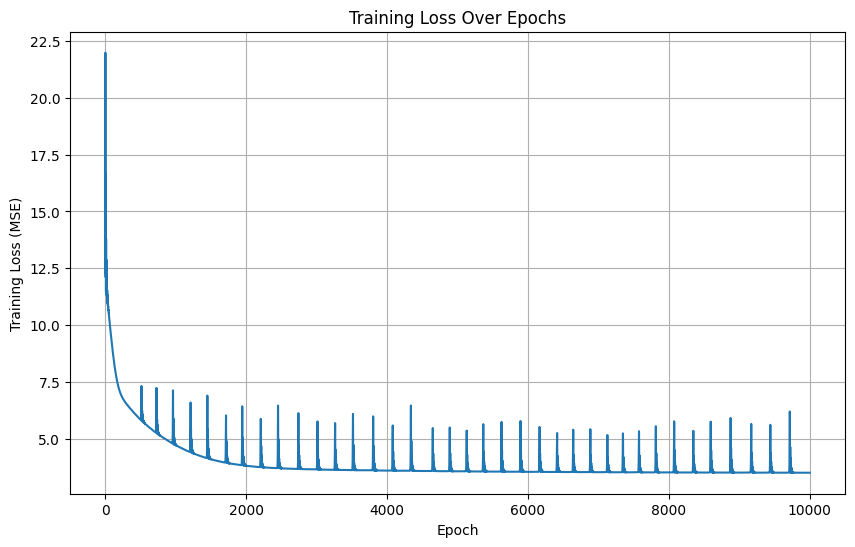

In [55]:
# prompt: train model using above train function with epoch 100 and validate it and visualize training error

import matplotlib.pyplot as plt

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# List to store training losses for visualization
training_losses = []

# Training loop
num_epochs = 10000
model.train()  # Set the model to training mode
for epoch in range(num_epochs):
  # Convert pandas DataFrames to PyTorch tensors
  inputs = torch.tensor(X_train.values, dtype=torch.float32).to(device)
  labels = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device) # Unsqueeze to match output shape

  # Forward pass
  outputs = model(inputs)
  loss = criterion(outputs, labels)

  # Backward and optimize
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Store the training loss
  training_losses.append(loss.item())

  if (epoch + 1) % 100 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Validate the model
print("\nValidating the model...")
validate_model(model, X_val, y_val, criterion)

# Visualize training error
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


In [47]:
# prompt: make regression model using sklearn linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a Linear Regression model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_linear = linear_model.predict(X_val)

# Evaluate the model
mse_linear = mean_squared_error(y_val, y_pred_linear)
r2_linear = r2_score(y_val, y_pred_linear)

print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression R-squared: {r2_linear}")

Linear Regression MSE: 4.063596442064901
Linear Regression R-squared: 0.9192996982957736



PyTorch Model Predictions and Errors:
Actual: 15.0000, Predicted: 16.3278, Error: -1.3278
Actual: 25.0000, Predicted: 19.5880, Error: 5.4120
Actual: 30.0000, Predicted: 28.4894, Error: 1.5106
Actual: 19.0000, Predicted: 17.6649, Error: 1.3351
Actual: 12.0000, Predicted: 11.8334, Error: 0.1666
Actual: 16.0000, Predicted: 17.2936, Error: -1.2936
Actual: 16.0000, Predicted: 14.9408, Error: 1.0592
Actual: 4.0000, Predicted: 3.4419, Error: 0.5581
Actual: 8.0000, Predicted: 10.5995, Error: -2.5995
Actual: 18.0000, Predicted: 19.1099, Error: -1.1099
Actual: 19.0000, Predicted: 20.0395, Error: -1.0395
Actual: 7.0000, Predicted: 7.0505, Error: -0.0505

Linear Regression Model Predictions and Errors:
Actual: 15.0000, Predicted: 16.4611, Error: -1.4611
Actual: 25.0000, Predicted: 19.4529, Error: 5.5471
Actual: 30.0000, Predicted: 28.5834, Error: 1.4166
Actual: 19.0000, Predicted: 17.7954, Error: 1.2046
Actual: 12.0000, Predicted: 11.9504, Error: 0.0496
Actual: 16.0000, Predicted: 17.2503, Error:

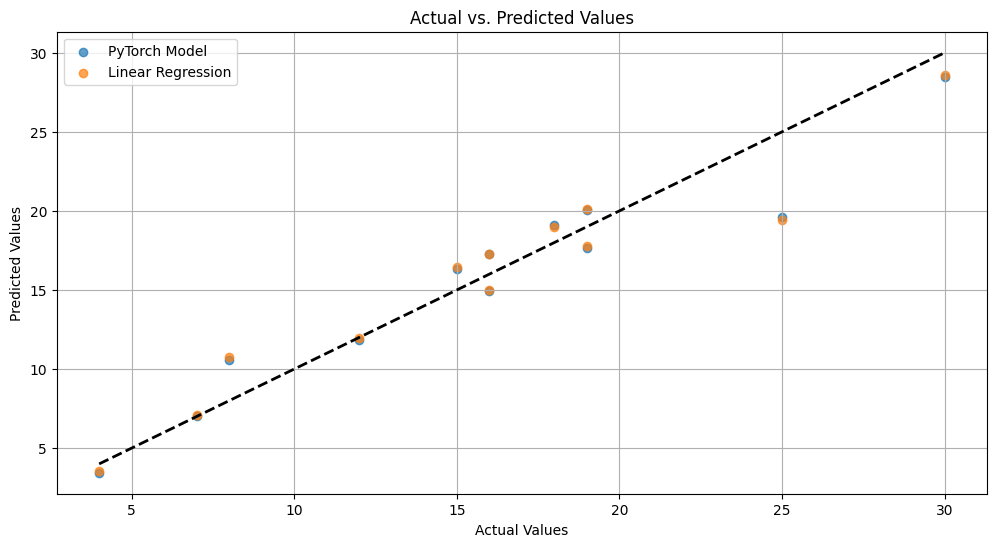

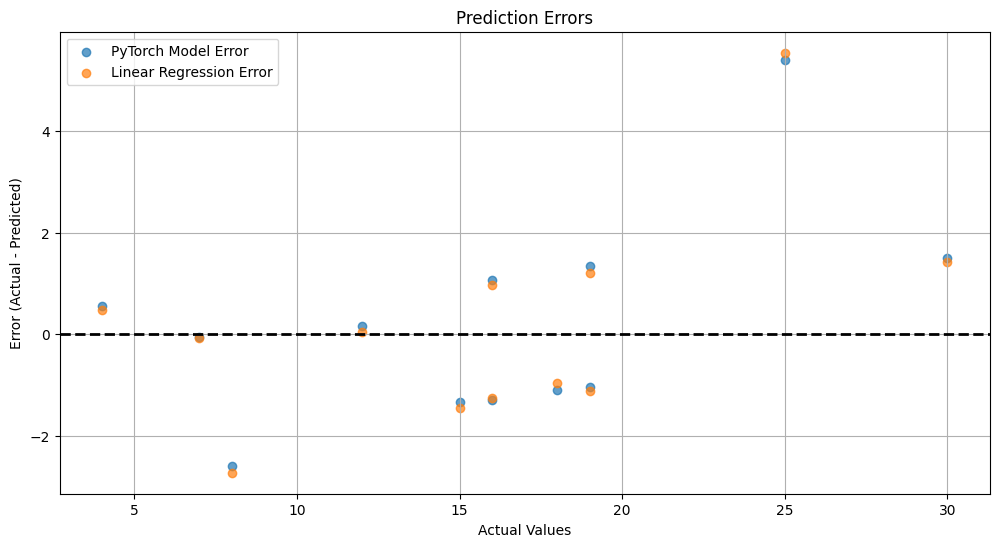

In [56]:
# prompt: print example of model prediction using both model with error

# Function to predict using the PyTorch model
def predict_pytorch(model, X):
  model.eval() # Set the model to evaluation mode
  with torch.no_grad():
    inputs = torch.tensor(X.values, dtype=torch.float32).to(device)
    predictions = model(inputs)
    return predictions.cpu().numpy().flatten() # Move to CPU and convert to numpy array

# Get predictions from both models on the validation set
y_pred_pytorch = predict_pytorch(model, X_val)
y_pred_linear = linear_model.predict(X_val)

# Calculate errors (residuals) for both models
errors_pytorch = y_val.values - y_pred_pytorch
errors_linear = y_val.values - y_pred_linear

# Print examples of predictions and actual values along with errors
print("\nPyTorch Model Predictions and Errors:")
for i in range(len(y_val)):
  print(f"Actual: {y_val.iloc[i]:.4f}, Predicted: {y_pred_pytorch[i]:.4f}, Error: {errors_pytorch[i]:.4f}")

print("\nLinear Regression Model Predictions and Errors:")
for i in range(len(y_val)):
  print(f"Actual: {y_val.iloc[i]:.4f}, Predicted: {y_pred_linear[i]:.4f}, Error: {errors_linear[i]:.4f}")

# You can also visualize the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_pytorch, alpha=0.7, label='PyTorch Model')
plt.scatter(y_val, y_pred_linear, alpha=0.7, label='Linear Regression')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2) # Diagonal line for perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# You can also visualize the errors
plt.figure(figsize=(12, 6))
plt.scatter(y_val, errors_pytorch, alpha=0.7, label='PyTorch Model Error')
plt.scatter(y_val, errors_linear, alpha=0.7, label='Linear Regression Error')
plt.axhline(0, color='k', linestyle='--', lw=2) # Zero error line
plt.xlabel('Actual Values')
plt.ylabel('Error (Actual - Predicted)')
plt.title('Prediction Errors')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# prompt: 두 모델의 accuracy도 출력해줘

from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R-squared for the PyTorch model
r2_pytorch = r2_score(y_val, y_pred_pytorch)
print(f"PyTorch Model R-squared (Accuracy Metric): {r2_pytorch}")


# We already have the R-squared and MSE for the Linear Regression model from the previous code
print(f"Linear Regression R-squared: {r2_linear}") # Already printed




PyTorch Model R-squared (Accuracy Metric): 0.921681032443896
Linear Regression R-squared: 0.9192996982957736


Epoch [100/10000], Training Loss: 3.4847, Validation Loss: 4.0444
Epoch [200/10000], Training Loss: 3.4823, Validation Loss: 4.0564
Epoch [300/10000], Training Loss: 3.4821, Validation Loss: 4.0538
Epoch [400/10000], Training Loss: 3.4820, Validation Loss: 4.0524
Epoch [500/10000], Training Loss: 3.4820, Validation Loss: 4.0515
Epoch [600/10000], Training Loss: 3.4819, Validation Loss: 4.0508
Epoch [700/10000], Training Loss: 3.4819, Validation Loss: 4.0501
Epoch [800/10000], Training Loss: 3.4819, Validation Loss: 4.0494
Epoch [900/10000], Training Loss: 3.4819, Validation Loss: 4.0488
Epoch [1000/10000], Training Loss: 3.4818, Validation Loss: 4.0483
Epoch [1100/10000], Training Loss: 3.4818, Validation Loss: 4.0478
Epoch [1200/10000], Training Loss: 3.4818, Validation Loss: 4.0474
Epoch [1300/10000], Training Loss: 3.4818, Validation Loss: 4.0471
Epoch [1400/10000], Training Loss: 3.4818, Validation Loss: 4.0469
Epoch [1500/10000], Training Loss: 3.4818, Validation Loss: 4.0468
Epoc

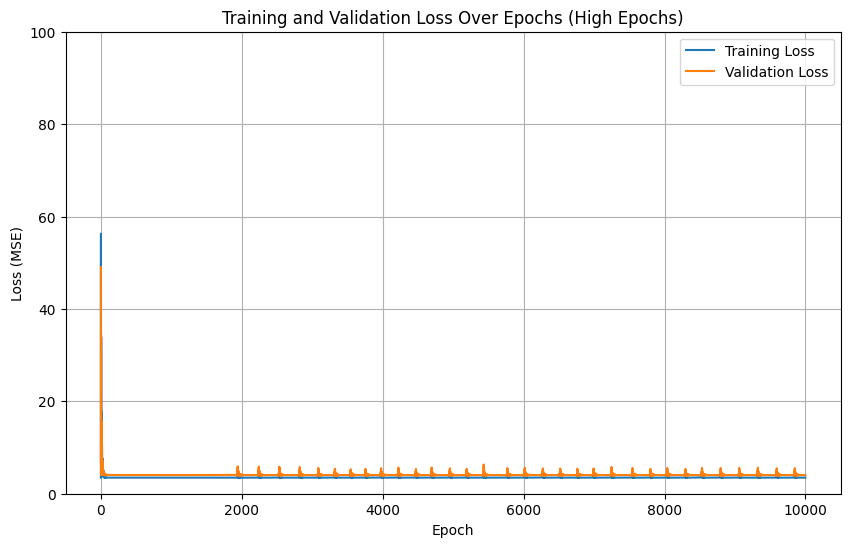


Final Validation Loss: 4.05211067199707


In [63]:
# prompt: show the overfitting using high epoch

# List to store validation losses for visualization
validation_losses = []

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation at the end of each epoch
num_epochs = 10000 # Increase epochs to demonstrate overfitting
model.train()  # Set the model to training mode

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
  # Convert pandas DataFrames to PyTorch tensors
  inputs_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
  labels_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device) # Unsqueeze to match output shape

  # Forward pass
  outputs_train = model(inputs_train)
  loss_train = criterion(outputs_train, labels_train)

  # Backward and optimize
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  # Store the training loss
  training_losses.append(loss_train.item())

  # --- Validation ---
  model.eval() # Set the model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
    inputs_val = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    labels_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

    outputs_val = model(inputs_val)
    loss_val = criterion(outputs_val, labels_val)
    validation_losses.append(loss_val.item())
  model.train() # Set the model back to training mode


  if (epoch + 1) % 100 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')

# Visualize training and validation error
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs (High Epochs)')
plt.legend()
plt.grid(True)
plt.ylim(0, 100) # Set a reasonable limit for y-axis for better visualization if losses are very high
plt.show()

# After the training and validation loop, you can optionally print final validation loss
print("\nFinal Validation Loss:", validation_losses[-1])

# The subsequent prediction and visualization code remains the same and can be used
# to compare the performance of the potentially overfitted PyTorch model
# against the Linear Regression model.
